In [2]:
! pip install rlcard

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import rlcard
import numpy as np
from rlcard.games.limitholdem import Dealer
from rlcard.games.base import Card
from rlcard.utils.utils import print_card
import random
import tkinter as tk #loads standard python GUI libraries
import time
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

Readme Section: In order to initialize a PokerGame instance you either use the user friendly built-in InitPlayers (pokergame.InitPlayers()) or you put the player types directly during the instantiaton of the class  e.g:
  
  pk = PokerGame(HumanAgent(), RandomAgent(), feedback)

feedback is an optional argument if you want the game to print info like who won, what actions are taken etc.

In [4]:

#Get the coresponding number of a rank
def rank_int(rank):
    if rank == '':
        return -1
    elif rank == 'T':
        return 1
    elif rank == 'J':
        return 2
    elif rank == 'Q':
        return 3
    elif rank == 'K':
        return 4
    elif rank == 'A':
        return 5
    return None


#A dealer class
class PokerDealer:
    #Initialize
    def __init__(self, np_random):
        self.deck = self.init_deck()
        self.np_random = np_random
        self.shuffle()
        self.pot = 0

    #Initialize a deck of 20 cards(10,J,Q,K,Α)
    def init_deck(self):
        suit_list = ['S', 'H', 'D', 'C']
        rank_list = ['T', 'J', 'Q', 'K', 'A']
        res = [Card(suit, rank) for suit in suit_list for rank in rank_list]
        return res

    #Shuffle the cards
    def shuffle(self):
         self.np_random.shuffle(self.deck)

    #Deal one card from the deck
    def deal_card(self):
        return self.deck.pop()


#A judger class
class PokerJudger:
    #Initialize
    def __init__(self, np_random):
        self.np_random = np_random

    #Judge the winner/winners of the game
    @staticmethod
    def judge_game(players, public_cards):
        winners = [0] * len(players)
        ranks = []
        for player in players:
            ranks.append(rank_int(player.hand.rank))
        max_rank = max(ranks)

        #If any of the players fold, the other player wins
        for i, player in enumerate(players):
           if players[i].status == 'folded':
               winners[i] = 1

        #If any of the players match both the public cards(3 of a kind) wins
        if sum(winners) < 1:
           for i, player in enumerate(players):
              if players[i].hand.rank == public_cards[0].rank and players[i].hand.rank == public_cards[1].rank:
                winners[i] = 1

        #Else, if any of the players match one public card(pair) wins. If both do, the player with the highest card rank wins
        if sum(winners) < 1:
            if (players[0].hand.rank == public_cards[0].rank or players[0].hand.rank == public_cards[1].rank) \
            and (players[1].hand.rank == public_cards[0].rank or players[1].hand.rank == public_cards[1].rank):
                  for i, player in enumerate(players):
                     if rank_int(players[i].hand.rank) == max_rank:
                         winners[i] = 1

            else:
                for i, player in enumerate(players):
                   if players[i].hand.rank == public_cards[0].rank or players[i].hand.rank == public_cards[1].rank:
                       winners[i] = 1

        #If non of the above conditions, the winner player is the one with the highest card rank
        if sum(winners) < 1:
           for i, player in enumerate(players):
              if rank_int(players[i].hand.rank) == max_rank:
                winners[i] = 1

        #Compute the total chips
        total = 0
        for p in players:
            total += p.in_chips
        each_win = float(total) / sum(winners)

        payoffs = []
        for i, _ in enumerate(players):
            if winners[i] == 1:
                payoffs.append(each_win - players[i].in_chips)
            else:
                payoffs.append(float(-players[i].in_chips))

        return payoffs


#A random agent class to play against
class RandomAgent:
  #Initialize
  def __init__(self):
    self.in_chips = 0
    self.win_chips = 0
    self.hand = None
    self.status = 'alive'

  #Predict the action given the curent state
  def step(self, state):
    legal_actions = state[1]
    while True:
      random_number = np.random.randint(4)
      if legal_actions[random_number] == 1:   #choose a legal action randomly
        break
    if random_number == 0:
      return 'call'
    elif random_number == 1:
      return 'fold'
    elif random_number == 2:
      return 'check'
    else:
      return 'raise'


#A threshold agent class to play against
class ThresholdAgent:
  #Initialize
  def __init__(self):
      self.in_chips = 0
      self.win_chips = 0
      self.hand = None
      self.status = 'alive'

  #Check for pair or 3 of a kind
  def has_pair(self, hand, public_hand):
      for i in public_hand:
        if hand.rank == i.rank:
          return True
      return False

  #Predict the action given the curent state
  def step(self, state):
      public_cards = state[0]
      legal_actions = state[1]
      #In the 1st round (public cards not yet revealed) raise or call in case of K or A
      if (public_cards[0] == None) and (self.hand.rank == 'K' or self.hand.rank == 'A'):
        if legal_actions[3] == 1:
          return 'raise'
        else:
          return 'call'
      #In the 2nd round (public cards revealed) raise or call in case of a pair or 3 of a kind
      elif (public_cards[0] != None) and (self.has_pair(self.hand, public_cards)):
        if legal_actions[3] == 1:
          return 'raise'
        else:
          return 'call'
      #Else, at any round check or fold
      elif legal_actions[2] == 1:
        return 'check'
      else:
        return 'fold'


#A human agent class to be able to play interactively against random or threshold agent
class HumanAgent:
  #Initialize
  def __init__(self):
    self.in_chips = 0
    self.win_chips = 0
    self.hand = None
    self.status = 'alive'

  #Predict the action given the curent state
  def step(self, state):
    legal_actions = state[1]
    str_legal_actions = list()
    actions_dic = {"0": "call", "1": "fold", "2": "check", "3": "raise"}
    for index, status in enumerate(legal_actions):
      if status == 1:
        str_legal_actions.append(actions_dic[str(index)])   #collect the legal actions as a list of strings
    public_cards = state[0]
    print("\n-----Your Hand-----")
    print_card(self.hand.get_index())

    if public_cards[0] != None:
      print("-------Public Cards---------")
      print_card(public_cards[0].get_index())
      print_card(public_cards[1].get_index())

    action = input("Please enter an action (call, fold, check or raise): ")     #read the user's input(only legal actions acceptable)
    while action not in str_legal_actions:
      print("This action is illegal or invalid.")
      action = input("Please enter an action (call, fold, check or raise): ")

    return action





class PokerGame:
  #Initialize
  def __init__(self, player1 = None, player2 = None, feedback = False):
    #Players, judger, dealer initializations
    self.np_random = np.random.RandomState()
    self.dealer = None
    self.judger = PokerJudger(self.np_random)
    self.player1 = player1
    self.player2 = player2
    #policy1 and 2 are True when Player 1 is PolicyAgent or player 2 is PolicyAgent
    self.policy1 = False
    self.policy2 = False
    #is True only when player1 is Policy and player2 is Threshold
    self.threshold2 = False
    self.feedback = feedback
    self.raise_r1 = 0
    #Bettings and cards initializations
    self.ante = 0.5
    self.bet = 1
    self.rounds = 2
    self.public_cards = [None, None]
    self.actions_dic = {0: "call", 1: "fold", 2: "check", 3: "raise"}

    ########## Q L E A R N I N G ############
    self.states = []
    self.actions = []
    self.rewards = []
    self.q1 = False
    self.q2 = False

  #Initialize Players (type, ID)
  def InitPlayers(self):

    #Choose what type of player you are
    while True:
      player_type = input("Choose your player type:(Random, Human, Threshold, Policy, QLearning) ")
      if  player_type in ["Random", "Threshold",  "Policy", "Human", "QLearning"]:
          break
      else:
          print("Invalid player type")

    #Choose to play against random or threshold agent
    while True:
      opp = input("Choose opponent type (Random, Threshold, Human, Policy, QLearning): ")
      if opp in ["Random", "Threshold",  "Policy", "Human", "QLearning"]:
          break
      else:
          print("Invalid opponent type.")
            
    #Generate random id
    prob = random.uniform(0, 1)
    if(prob<0.5):
        id = "1"
    else:
        id = "2" 
    
    #Define player1 and player2 from user's inputs
    if id == "1" and player_type == "Human":
      self.player1 = HumanAgent()
      if opp == "Random":
          self.player2 = RandomAgent()
      elif opp == "Threshold":
          self.player2 = ThresholdAgent()
      elif opp == "Human":
          self.player2 = HumanAgent()
      elif opp == "Policy" :
          self.policy2 = True
          self.player2 = PolicyAgent(2, "Threshold")
      elif opp == "QLearning" :
          self.q2 = True
          self.player2 = QLearningAgent(False,0.5,0.5,0.01)
    elif id == "1" and player_type == "Random":
      self.player1 = RandomAgent()
      if opp == "Random":
          self.player2 = RandomAgent()
      elif opp == "Threshold":
          self.player2 = ThresholdAgent()
      elif opp == "Human":
          self.player2 = HumanAgent()
      elif opp == "Policy" :
          self.policy2 = True
          self.player2 = PolicyAgent(2, "Random")
      elif opp == "QLearning" :
          self.q2 = True
          self.player2 = QLearningAgent(False,0.1,0.9,0)
    elif id == "1" and player_type == "Threshold":
      self.player1 = ThresholdAgent()
      if opp == "Random":
          self.player2 = RandomAgent()
      elif opp == "Threshold":
          self.player2 = ThresholdAgent()
      elif opp == "Human":
          self.player2 = HumanAgent()
      elif opp == "Policy" :
          self.policy2 = True
          self.player2 = PolicyAgent(2, "Random")
      elif opp == "QLearning" :
          self.q2 = True
          self.player2 = QLearningAgent(False,0.5,0.5,0.01)
    elif id == "1" and player_type == "Policy":
      self.policy1 = True
      self.player1 = PolicyAgent(1, "Random")
      if opp == "Random":
          self.player2 = RandomAgent()
      elif opp == "Threshold":
          self.threshold2 == True
          self.player2 = ThresholdAgent()
      elif opp == "Human":
          self.player2 = HumanAgent()
      elif opp == "Policy" :
          self.policy2 = True
          self.player2 = PolicyAgent(2, "Random")
      elif opp == "QLearning" :
          self.q2 = True
          self.player2 = QLearningAgent()
    elif id == "1" and player_type == "QLearning":
      self.q1 = True
      if opp == "Random":
          self.player1 = QLearningAgent(False, 0.1, 0.9, 0)
          self.player2 = RandomAgent()
      elif opp == "Threshold":
          self.player1 = QLearningAgent(False, 0.1, 0.1, 0.05)
          self.player2 = ThresholdAgent()
      elif opp == "Human":
          self.player1 = QLearningAgent(False, 0.1, 0.9, 0)
          self.player2 = HumanAgent()
      elif opp == "Policy" :
          self.policy2 = True
          self.player1 = QLearningAgent(False, 0.1, 0.9, 0)
          self.player2 = PolicyAgent(2, "Random")
      elif opp == "QLearning" :
          self.q2 = True
          self.player1 = QLearningAgent()
          self.player2 = QLearningAgent()
    elif id == "2" and player_type == "Human":
      self.player2 = HumanAgent()
      if opp == "Random":
          self.player1 = RandomAgent()
      elif opp == "Threshold":
          self.player1 = ThresholdAgent()
      elif opp == "Human":
          self.player1 = HumanAgent()
      elif opp == "Policy" :
          self.policy1 = True
          self.player1 = PolicyAgent(1, "Random")
      elif opp == "QLearning" :
          self.q1 = True
          self.player1 = QLearningAgent(False,0.5,0.5,0.01)
    elif id == "2" and player_type == "Random":
      self.player2 = RandomAgent()
      if opp == "Random":
          self.player1 = RandomAgent()
      elif opp == "Threshold":
          self.player1 = ThresholdAgent()
      elif opp == "Human":
          self.player1 = HumanAgent()
      elif opp == "Policy" :
          self.policy1 = True
          self.player1 = PolicyAgent(1, "Random")
      elif opp == "QLearning" :
          self.q1 = True
          self.player1 = QLearningAgent(False,0.1,0.9,0)
    elif id == "2" and player_type == "Threshold":
      self.player2 = ThresholdAgent()
      if opp == "Random":
          self.player1 = RandomAgent()
      elif opp == "Threshold":
          self.player1 = ThresholdAgent()
      elif opp == "Human":
          self.player1 = HumanAgent()
      elif opp == "Policy" :
          self.policy1 = True
          self.player1 = PolicyAgent(1, "Random")
      elif opp == "QLearning" :
          self.q1 = True
          self.player1 = QLearningAgent(False, 0.1, 0.1, 0.05)
    elif id == "2" and player_type == "Policy":
      self.policy2 = True
      if opp == "Random":
          self.player1 = RandomAgent()
          self.player2 = PolicyAgent(2, "Random")
      elif opp == "Threshold":
          self.player1 = ThresholdAgent()
          self.player2 = PolicyAgent(2, "Threshold")
      elif opp == "Human":
          self.player2 = PolicyAgent(2, "Random")
          self.player1 = HumanAgent()
      elif opp == "Policy" :
          self.policy1 = True
          self.player2 = PolicyAgent(2, "Random")
          self.player1 = PolicyAgent(1, "Random")
      elif opp == "QLearning" :
          self.q1 = True
          self.player2 = PolicyAgent(2, "Random")
          self.player1 = QLearningAgent()
    elif id == "2" and player_type == "QLearning":
      self.q2 = True
      if opp == "Random":
          self.player1 = RandomAgent()
          self.player2 = QLearningAgent(False,0.1,0.9,0)
      elif opp == "Threshold":
          self.player1 = ThresholdAgent()
          self.player2 = QLearningAgent(False,0.5,0.5,0.01)
      elif opp == "Human":
          self.player1 = HumanAgent()
          self.player2 = QLearningAgent(False,0.5,0.5,0.01)
      elif opp == "Policy" :
          self.policy1 = True
          self.player1 = PolicyAgent(2, "Random")
          self.player2 = QLearningAgent()
      elif opp == "QLearning" :
          self.q1 = True
          self.player1 = QLearningAgent()
          self.player2 = QLearningAgent()
    else:
      print("Something went wrong in InitPlayers")


  #Play one game of poker
  def playGame(self):
    #Initialization of Dealer
    self.dealer =  PokerDealer(self.np_random)
    #Hands and chips initializations
    self.player1.in_chips = 0
    self.player2.in_chips = 0
    self.player1.in_chips += self.ante
    self.player2.in_chips += self.ante
    self.player1.win_chips = 0
    self.player2.win_chips = 0
    self.player1.hand = self.dealer.deal_card()
    self.player2.hand = self.dealer.deal_card()
    self.player1.status="alive"
    self.player2.status="alive"
    self.raise_r1 = 0
    pre_public_cards = [self.dealer.deal_card(), self.dealer.deal_card()]
    if(self.policy1 == True):
      self.player1.train(pre_public_cards)

    if(self.policy2 == True):
      self.player2.train(pre_public_cards)
    #2 rounds in total
    for i in range(self.rounds):
        if self.feedback:
            print("\nRound "+str(i+1))
        call_status = 0
        check_status = 1
        fold_status = 0
        raise_status = 1
        raise_count = 0
        raise_sum = 0


        #Action 1 for player 1
        if(self.feedback):
            print("Player 1's turn")
        legal_actions = [call_status, fold_status, check_status, raise_status]
        #check if player 1 is Q agent to use appropriate step function
        if(self.q1 == True ):
          state = (self.player1.hand, self.public_cards, i, legal_actions)
          self.states.append(state)
          #check whether q agent is in training phase or in testing phase
          if(self.player1.q_learn == True):
            action1 = self.player1.step_train(state)
          else:
            action1 = self.player1.step_test(state)
          self.actions.append(action1)
        #check whether player1 is policy agent and choose action from current state using the policy table (pi)
        elif(self.policy1 == True):
            if(i==0):
                action_num = self.player1.pi.get(0)
            elif(self.raise_r1==0):
                action_num = self.player1.pi.get(3)
            elif(self.raise_r1==1):
                action_num = self.player1.pi.get(4)
            else:
                action_num = self.player1.pi.get(5)

            action1 = self.actions_dic.get(action_num)
        #in every other case use the step function of the agent
        else:
            action1 = self.player1.step([self.public_cards, legal_actions])

        if action1 == 'raise':
            if(self.q1 == True and self.player1.q_learn == True):
                self.rewards.append(0)
            #Update legal action space
            call_status = 1
            check_status = 0
            fold_status = 1
            raise_status = 1
            raise_count += 1
            raise_sum += self.bet
            self.player1.in_chips += raise_sum
            legal_actions = [call_status, fold_status, check_status, raise_status]
            if self.feedback:
                print("Player 1 has raised.")
        elif action1 == 'check':
            if(self.q1 == True and self.player1.q_learn == True):
                self.rewards.append(0)
            fold_status = 0
            call_status = 0
            check_status = 1
            raise_status = 1
            legal_actions = [call_status, fold_status, check_status, raise_status]
            if self.feedback:
                print("Player 1 has checked.")
        else:
            print("Invalid Action")
            exit(0)

        #Action for player 2
        if(self.feedback):
            print("Player 2's turn")
        #Check whether player 2 is q agent
        if(self.q2 == True):
          state = (self.player2.hand, self.public_cards, i, legal_actions)
          self.states.append(state)
          #check if player 2 is in training phase or not
          if self.player2.q_learn == True:
            action2 = self.player2.step_train(state)
          else:
            action2 = self.player2.step_test(state)
          self.actions.append(action2)
          #print(state)

        #check whether player2 is policy agent and access its policy table to get correct action from current state
        elif(self.policy2 == True):
            if(action1 == 'raise' and i == 0):
                action_num = self.player2.pi.get(1)
            elif(action1 == 'check' and i == 0):
                action_num = self.player2.pi.get(0)
            elif(self.raise_r1 == 0 and action1 == 'raise'):
                action_num = self.player2.pi.get(3)
            elif(self.raise_r1 == 0 and action1 == 'check'):
                action_num = self.player2.pi.get(2)
            elif(self.raise_r1 == 1 and action1 == 'raise'):
                action_num = self.player2.pi.get(5)
            elif(self.raise_r1 == 1 and action1 == 'check'):
                action_num = self.player2.pi.get(4)
            elif(self.raise_r1 == 2 and action1 == 'raise'):
                action_num = self.player2.pi.get(7)
            elif(self.raise_r1 == 2 and action1 == 'check'):
                action_num = self.player2.pi.get(6)
            else:
                print("Something went wrong")
                exit(0)
            action2 = self.actions_dic.get(action_num)
        else:
            action2 = self.player2.step([self.public_cards, legal_actions])

        if action2 == 'raise':
            if(self.q2 == True):
                self.rewards.append(0)
            raise_count += 1
            check_status = 0
            raise_status = 0
            fold_status = 1
            call_status = 1
            raise_sum += self.bet
            self.player2.in_chips += raise_sum
            legal_actions = [call_status, fold_status, check_status, raise_status]
            if self.feedback:
                print("Player 2 has raised.")
        elif action2 == 'call':
            if(self.q2 == True):
                self.rewards.append(0)
            self.player2.in_chips += raise_sum
            if self.feedback:
                print("Player 2 has called.")
        elif action2 == 'fold':
            self.player1.win_chips = self.player2.in_chips
            self.player2.win_chips = -self.player2.in_chips
            self.player2.status = 'folded'
            if(self.q2 == True ):
                self.rewards.append(self.player2.win_chips)
            if self.feedback:
                print("Player 2 has folded.")
            break
        else:
            if(self.q2 == True):
                self.rewards.append(0)
            if self.feedback:
                print("Player 2 has checked.")



        #Action for player 1 (response to possible raise)
        if(self.feedback):
            print("Player 1's turn")
        if action1 + action2 == 'raiseraise' or action1 + action2 == 'checkraise':
            #Checking what agent type is Player 1
            if(self.q1 == True):
                state = (self.player1.hand, self.public_cards, i, legal_actions)
                self.states.append(state)
                if(self.player1.q_learn == True):
                    action3 = self.player1.step_train(state)
                else:
                    action3 = self.player1.step_test(state)
                self.actions.append(action3)
            elif(self.policy1 == True and self.threshold2 == True):
                if(i==0 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(1)

                elif(i==0 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(2)

                elif(self.raise_r1==0 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(6)

                elif(self.raise_r1==0 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(7)

                elif(self.raise_r1==1 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(8)

                elif(self.raise_r1==1 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(9)

                elif(self.raise_r1==1 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(9)

                elif(self.raise_r1==2 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(10)

                #print(action_num)
                action3 = self.actions_dic.get(action_num)
            elif(self.policy1 == True):
                if(i==0 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(1)

                elif(i==0 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(2)

                elif(self.raise_r1==0 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(6)

                elif(self.raise_r1==1 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(7)

                elif(self.raise_r1==0 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(7)

                elif(self.raise_r1==1 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(8)

                elif(self.raise_r1==2 and action1 + action2 == 'checkraise'):
                    action_num = self.player1.pi.get(8)

                elif(self.raise_r1==2 and action1 + action2 == 'raiseraise'):
                    action_num = self.player1.pi.get(9)

                #print(action_num)
                action3 = self.actions_dic.get(action_num)
            else:
                action3 = self.player1.step([self.public_cards, legal_actions])

            if action3 == 'call':
                if(self.q1 == True and self.player1.q_learn == True):
                    self.rewards.append(0)
                self.player1.in_chips += self.bet
                if self.feedback:
                    print("Player 1 has called.")
            elif action3 == 'fold':
                self.player1.status = 'folded'
                self.player2.win_chips = self.player1.in_chips
                self.player1.win_chips = -self.player1.in_chips
                if(self.q1 == True and self.player1.q_learn == True):
                    self.rewards.append(self.player1.win_chips)
                if self.feedback:
                    print("Player 1 has folded.")
                break
            else:
                #print("3rd raise")
                exit(0)

        if i == 0:
            self.public_cards = pre_public_cards
            self.raise_r1 = raise_count

    #Judge and print winners and winchips
    players = [self.player1, self.player2]



    if self.feedback:
        print("PLayer 1 has played "+str(self.player1.in_chips) + " chips, Player 2 has played: "+ str(self.player2.in_chips) + " chips")
        print('Hands'+" "+self.player1.hand.rank+" "+ self.player2.hand.rank)


    #print("Ranks: "+ str(players[0].hand.rank) + ' '+ str(players[1].hand.rank))
    if (self.player1.win_chips == 0 and self.player2.win_chips == 0):
        if self.feedback:
            print(self.public_cards[0].rank, self.public_cards[1].rank)
        if None in self.public_cards:
            print("Xasame")
        winnings = self.judger.judge_game(players, self.public_cards)
        self.player1.win_chips = winnings[0]
        self.player2.win_chips = winnings[1]

      ########## Q L E A R N I N G ############
    if(self.q1 == True and self.player1.status == 'alive'):
       state = (self.player1.hand, self.public_cards, self.rounds+1, legal_actions)
       self.states.append(state)
       action_terminate = None
       self.actions.append(action_terminate)
       self.rewards.append(self.player1.win_chips)
    if(self.q2 == True and self.player1.status == 'alive'):
      state = (self.player2.hand, self.public_cards, self.rounds+1, legal_actions)
      action_terminate = None
      self.actions.append(action_terminate)
      self.states.append(state)
      self.rewards.append(self.player2.win_chips)

    if ( self.player1.win_chips > self.player2.win_chips and self.feedback):
        print("Player 1 won: "+ str(self.player1.win_chips))
    elif ( self.player1.win_chips < self.player2.win_chips and self.feedback):
        print("Player 2 won: "+ str(self.player2.win_chips))
    else:
        if self.feedback:
            print("Pot split in half: "+ str(self.player2.win_chips))
    if self.feedback:
        print(self.player1.win_chips, self.player2.win_chips)
    return self.player1.win_chips, self.player2.win_chips


########## Q L E A R N I N G ############
class QLearningAgent:
    def __init__(self, q_learn=False, alpha=0.5, gamma=0.9, epsilon=0.1):
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.q_table = {}  # Q-table
        self.q_learn = q_learn

    def get_state_key(self, state):
        # Convert the state to a unique string key for the Q-table
        #if state is None:
        #  return "default_key"
        hand_key = state[0].rank
        if None in state[1]:
            public_cards_key = "-".join(str([hand for hand in state[1]]))
        else:
            public_cards_key = "-".join([hand.rank for hand in state[1]])
        round_key = str(state[2])
        legal_actions_key = "-".join(str([legal for legal in state[3]]))
        return f"{hand_key}_{public_cards_key}_{round_key}_{legal_actions_key}"


    #from current state return the action that corresponds to the highest q_value
    def get_best_action(self, state):
        actions_dic = {0: "call", 1: "fold", 2: "check", 3: "raise"}
        state_key = self.get_state_key(state)
        legal_actions = state[3]
        q_values = self.q_table.get(state_key, np.zeros(4))
        max_q_value = np.max(q_values)
        best_actions = [action for action, q_value in enumerate(q_values) if q_value == max_q_value and legal_actions[action] == 1]
        best_actions_str = []
        for action_num in best_actions:
            best_actions_str.append(actions_dic.get(action_num))
        if (best_actions_str == []):
            print('s')
        return np.random.choice(best_actions_str)

    #update the q_table with the new q values
    def update_q_table(self, state, action, next_state, reward):
        state_key = self.get_state_key(state)
        if next_state == None:
            q_values = self.q_table.get(state_key, np.zeros(4))
            reverse_actions_dic = {"call": 0, "fold":1 , "check":2 , "raise":3 }
            action = reverse_actions_dic.get(action)
            q_values[action] += self.alpha * (reward - q_values[action])
            for index, value in enumerate(state[3]):
                if value == 0:
                    q_values[index] = -1000
                else:
                    continue
            self.q_table[state_key] = q_values
        else:
            next_state_key = self.get_state_key(next_state)
            q_values = self.q_table.get(state_key, np.zeros(4))
            next_q_values = self.q_table.get(next_state_key, np.zeros(4))
            reverse_actions_dic = {"call": 0, "fold":1 , "check":2 , "raise":3 }
            action = reverse_actions_dic.get(action)
            q_values[action] += self.alpha * (reward + self.gamma * np.max(next_q_values) - q_values[action])
            for index, value in enumerate(state[3]):
                if value == 0:
                    q_values[index] = -1000
                else:
                    continue
            self.q_table[state_key] = q_values

    #epsilon defines the exploration.
    #While training there is a chance of exploring or choosing the action with the best q_value
    def step_train(self, state):
        #print(state)
        legal_actions = state[3]
        actions_dic = {0: "call", 1: "fold", 2: "check", 3: "raise"}
        if np.random.rand() < self.epsilon:
            action_num =  np.random.choice([action for action, legal in enumerate(legal_actions) if legal == 1])
            action = actions_dic.get(action_num)
            return action
        else:
            return self.get_best_action(state)

    def step_test(self, state):
        #print(state)
        return self.get_best_action(state)


#A policy agent class
class PolicyAgent:
  #Initialize with player id(1 or 2) and opponent type(random or threshold)
  def __init__(self, ID, opp, gamma = 0.9, epsilon = 0.0000001):
        self.in_chips = 0
        self.win_chips = 0
        self.hand = None
        self.status = 'alive'
        self.ID = ID
        self.opponent = opp
        self.pi = None
        self.gamma = gamma
        self.epsilon = epsilon

  #Find the public card with the highest rank
  def max_public(self, public_cards):
        ranks = []
        for i in public_cards:
          ranks.append(rank_int(i.rank))
        if ranks[0] > ranks[1]:
          return public_cards[0]
        else:
          return public_cards[1]

  #Find the probability of Threshold having one pair or three of a kind but no A or K
  def pair_probability(self, public_cards):
        #if you dont have pair or 3 of a kind
        if self.hand not in public_cards:
            if(public_cards[0].rank == public_cards[1].rank):
                return 2/17
            else:
                return 6/17
        #if you have pair or 3 of a kind but also not A or K
        elif (self.hand.rank != 'A' or self.hand.rank != 'K') and self.hand in public_cards:
            if(public_cards[0].rank == public_cards[1].rank):
                return 1/17
            else:
                return 5/17
        elif (self.hand.rank == 'A' or self.hand.rank == 'K') and self.hand in public_cards:
            #if public cards == AA or KK or AK or KA then Thershold does not have pair
            if(public_cards[0].rank == public_cards[1].rank or ('K' in [public_cards[0].rank, public_cards[1].rank] and 'A' in [public_cards[0].rank, public_cards[1].rank])):
                return 0
            else:
                return 3/17

  #Find the probability of Threshold having one pair or three of a kind with A or K
  def pair_probability_high(self,public_cards):
      #if public cards are AA or KK
      if (public_cards[0] == public_cards[1] and (public_cards[0].rank == 'A' or public_cards[0].rank == 'K')):
          return 0.5
      #if 2 different public cards down and only one of them is A or K
      elif ((public_cards[0].rank == 'A' or public_cards[0].rank == 'K') and (public_cards[1].rank != 'A' or public_cards[1].rank != 'K')):
          return 0.5
      #if public cards are AK or KA
      elif ((public_cards[0].rank == 'A' or public_cards[0].rank == 'K') and (public_cards[1].rank == 'A' or public_cards[1].rank == 'K')):
          return 1
      else:
          return 0


  #Find probability in Round 2 of PolicyAgent  winning if Threshold has no A,K or pair
  def no_pair_high(self, public_cards):
      if self.hand.rank == 'Q' or self.hand in public_cards:
          w_prob = 1
      elif self.hand.rank == 'J':
          w_prob = 13/17
      else :
          w_prob = 9/17
      return w_prob

  #Find probability in Round 2 of PolicyAgent winning if Threshold has not A,K but has pair
  def pair_no_high(self, public_cards):
      if(self.max_public(public_cards).rank == self.hand.rank):
           w_prob = 1
      elif((self.hand.rank == 'K' or self.hand.rank == 'Q' ) and self.hand in public_cards):
           w_prob = 1
      elif(self.hand in public_cards and public_cards[0] == public_cards[1]):
           w_prob = 1
      elif(self.hand.rank == 'J' and self.hand in public_cards):
           w_prob = 14/17
      elif(self.hand.rank == 'T' and self.hand in public_cards):
           w_prob = 11/17
      else:
          w_prob = 0
      return w_prob

  #Find probability in Round 2 of PolicyAgent winning if Threshold has A,K but no pair
  def high_no_pair(self, public_cards):
        if(self.hand in public_cards or self.hand.rank == 'A'):
            w_prob = 1
        elif(self.hand.rank == 'K'):
            w_prob = 14/17
        else:
            w_prob = 0

        return w_prob

  #Find probability in Round 2 of PolicyAgent winning if Threshold has AA or KK
  def high_pair(self,public_cards):
      if(self.max_public(public_cards).rank == self.hand.rank):
          w_prob = 1
      else:
          w_prob = 0
      return w_prob

  #Find probability in Round 1 of  Threshold having A or K
  def has_high(self):
      if(self.hand == 'A' or self.hand == 'K'):
          high_prob = 7/19
      else:
          high_prob = 8/19
      return high_prob


  #Compute the probabilities of winning and losing against random opponent
  def evaluate_vs_Random(self, public_cards):
        #Round 1
        if public_cards == [None, None] and self.hand.rank == 'A':
            w_prob = 1
            l_prob = 0
        elif public_cards == [None, None] and self.hand.rank == 'K':
            w_prob = 4/5
            l_prob = 1/5
        elif public_cards == [None, None] and self.hand.rank == 'Q':
            w_prob = 3/5
            l_prob = 2/5
        elif public_cards == [None, None] and self.hand.rank == 'J':
            w_prob = 2/5
            l_prob = 3/5
        elif public_cards == [None, None] and self.hand.rank == 'T':
            w_prob = 1/5
            l_prob = 4/5

        #Round 2
        #2 same public cards
        if public_cards[0].rank == public_cards[1].rank:
            if self.hand.rank == public_cards[0].rank:
                w_prob = 1
                l_prob = 0
            elif self.hand.rank == 'A':
                w_prob = 15/17
                l_prob = 2/17
            elif self.hand.rank == 'K':
                #Other player wins with 3 of a kind or A
                w_prob = 11/17
                l_prob = 6/17
            elif self.hand.rank == 'Q':
                if rank_int(public_cards[0].rank) < 3:
                    w_prob = 7/17
                    l_prob = 10/17
                else:
                    w_prob = 11/17
                    l_prob = 6/17
            elif self.hand.rank == 'J':
            #Other player wins with 3 of a kind or A, K, Q
            #If 2 10's are dealt then you lose if other player has one of 4 remaining A's | K's | Q's
                if public_cards[0].rank == 'T':
                    w_prob = 3/17
                    l_prob = 14/17
            #If other player doesnt have 3 of a kind but 2 A's | K's .... are dealt, he has one of 4 remaining A's | K's | Q's (depending which of them are not dealt)
                else:
                    w_prob = 7/17
                    l_prob = 10/17
            else:
            #Other player wins with 3 of a kind or A, K, Q, J
                w_prob = 3/17
                l_prob = 14/17

        #2 different public cards
        else:
            #If player matches one of the public cards(pair)
            if self.hand.rank == public_cards[0].rank or self.hand.rank == public_cards[1].rank:
                #If he matches the public card with the highest rank, the player wins
                if self.hand.rank == self.max_public(public_cards):
                    w_prob = 1
                    l_prob = 0
                #Else, the other player could match the highest public card and win
                else:
                    w_prob = 14/17
                    l_prob = 3/17
            #Else, with no pair or 3 of a kind:
            #If the player has A, he wins if the other player doesn't have a pair
            elif self.hand.rank == 'A':
                w_prob = 11/17
                l_prob = 6/17
            #If the player has K, he wins if the other player doesn't have a pair or A
            elif self.hand.rank == 'K':
                w_prob = 7/17
                l_prob = 10/17
            #If the player has Q, he wins if the other player doesn't have a pair or A or K
            elif self.hand.rank == 'Q':
                #If J and 10 are the public cards, then the other player can have A or K with probability 8/17
                if (public_cards[0].rank == 'J' and public_cards[1].rank == 'T') or (public_cards[0].rank == 'T' and public_cards[1].rank == 'J'):
                    w_prob = 3/17
                    l_prob = 14/17
                #Else, the other player can have A or K with probability 4/17 (A or K are in public cards but the other player doesn't have pair)
                else:
                    w_prob = 7/17
                    l_prob = 10/17
            #If the player has J, he wins if the other player has 10 or J
            elif self.hand.rank == 'J':
                if public_cards[0].rank == 'T' or  public_cards[1].rank == 'T':
                    w_prob = 3/17
                    l_prob = 14/17
                else:
                    w_prob = 7/17
                    l_prob = 10/17
            #If the player has 10, he wins only if the other player has 10
            else:
                w_prob = 3/17
                l_prob = 14/17

        return w_prob, l_prob

  def get_P(self, penalty, public_cards):
     w_prob2, l_prob2 = self.evaluate_vs_Random(public_cards)
     #print(w_prob2)
     #print(l_prob2)
     pair_prob = self.pair_probability(public_cards)
     pair_prob_high = self.pair_probability_high(public_cards)
     w_prob_no_pair_high = self.no_pair_high(public_cards)
     w_prob_pair_no_high = self.pair_no_high(public_cards)
     w_prob_high_no_pair = self.high_no_pair(public_cards)
     w_prob_high_pair = self.high_pair(public_cards)
     prob_high = self.has_high()

     #If agent is player 2 against random opponent
     if self.ID == 2 and self.opponent == 'Random':
            P = {
            # Round 1
            #We Suppose that Agent is Player 2
            #Player 1 has checked (possible initial state)
            0: {

                #Call (Illegal)
                0: [(1, 0, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 0, penalty, False) #remain to same state
                ],

                #Check , Go to round 2
                2: [(0.5, 2, 0, False), #go round 2 => 0 raise (2 initial states)
                    (0.5, 3, 0, False)  #go round 2 => 0 raise (2 initial states)

                ],
                #Raise
                3: [(0.25, 4, 0, False), #check raise call go round 2 => 1 raise (2 initial states)
                    (0.25, 5, 0, False), #check raise call go round 2 => 1 raise (2 initial states)
                    (0.5, 9, 0.5, True)   #check raise fold
                ]
            },
            #Player 1 has raised (possible initial state)
            1: {
                #Call
                0: [(0.5, 4, 0, False), #raise call go round 2 => 1 raise (2 initial states)
                    (0.5, 5, 0, False)  #raise call go round 2 => 1 raise (2 initial states)
                ],
                #Fold
                1: [(1, 8, -0.5, True) #raise fold

                ],

                #Check (Illegal)
                2: [(1, 1, penalty, False) #remain to same state
                ],

                #Raise
                3: [(0.25, 6, 0, False), #raise raise call 2 raises (2 initial states)
                    (0.25, 7, 0, False), #raise raise call 2 raises (2 initial states)
                    (0.5, 9, 1.5, True)  #raise raise fold
                ]
            },
            # Round 2 after: 0 raises
            #Player 1 has checked (possible initial state)
            2: {

                #Call (Illegal)
                0: [(1, 2, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 2, penalty, False) #remain to same state

                ],
                #Check
                2: [(w_prob2, 9, 0.5, True), #check check
                    (l_prob2, 8, -0.5, True)
                ],
                #Raise
                3: [((0.5)*w_prob2, 9, 1.5, True), #check raise call , 0 + 1 raises
                    ((0.5)*l_prob2, 8, -1.5, True), #check raise call,  0 + 1 raises
                    (0.5, 9, 0.5, True)   #check raise fold
                ]
            },
            # Round 2 after: 0 raises
            #Player 1 has raised (possible initial state)
            3: {
                #Call
                0: [(w_prob2, 9, 1.5, True),
                    (l_prob2, 8, -1.5, True)
                ],
                #Fold
                1: [(1, 8, -1.5, True)
                ],

                #Check (Illegal)
                2: [(1, 3, penalty, False) #remain to same state
                ],

                #Raise
                3: [(0.5*w_prob2, 9, 2.5, True), #raise raise call,  0 + 2 raises
                    (0.5*l_prob2, 8, -2.5, True),  #raise raise call,  0 + 2 raises
                    (0.5, 9, 2.5, True)   #raise raise fold
                ]
            },
            # Round 2 after: 1 raise  4,5 reserved
            #Player 1 has checked (possible initial state)
            4: {
                #Call (Illegal)
                0: [(1, 4, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 4, penalty, False) #remain to same state
                ],
                #Check
                2: [(w_prob2, 9, 1.5, True), #check check
                    (l_prob2, 8, -1.5, True)
                ],
                #Raise
                3: [((0.5)*w_prob2, 9, 2.5, True), #check raise call , 0 + 1 raises
                    ((0.5)*l_prob2, 8, -2.5, True), #check raise call,  0 + 1 raises
                    (0.5, 9, 1.5, True)   #check raise fold
                ]
            },
            # Round 2 after: 1 raises
            #Player 1 has raised (possible initial state)
            5: {
                #Call
                0: [(w_prob2, 9, 2.5, True),
                    (l_prob2, 8, -2.5, True)
                ],
                #Fold
                1: [(1, 8, -2.5, True)
                ],

                #Check (Illegal)
                2: [(1, 5, penalty, False) #remain to same state
                ],

                #Raise
                3: [(0.5*w_prob2, 9, 3.5, True), #raise raise call,  0 + 2 raises
                    (0.5*l_prob2, 8, -3.5, True),  #raise raise call,  0 + 2 raises
                    (0.5, 9, 3.5, True)   #raise raise fold
                ]
            },

            # Round 2 after: 2 raises  6,7 reserved
            #Player 1 has checked (possible initial state)
            6: {
                #Call (Illegal)
                0: [(1, 6, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 6, penalty, False) #remain to same state

                ],
                #Check
                2: [(w_prob2, 9, 2.5, True), #check check
                    (l_prob2, 8, -2.5, True)
                ],
                #Raise
                3: [((0.5)*w_prob2, 9, 3.5, True), #check raise call , 0 + 1 raises
                    ((0.5)*l_prob2, 8, -3.5, True), #check raise call,  0 + 1 raises
                    (0.5, 9, 2.5, True)   #check raise fold
                ]
            },
            # Round 2 after: 2 raises
            #Player 1 has raised (possible initial state)
            7: {
                #Call
                0: [(w_prob2, 9, 3.5, True),
                    (l_prob2, 8, -3.5, True)
                ],
                #Fold
                1: [(1, 8, -3.5, True)
                ],

                #Check (Illegal)
                2: [(1, 7, penalty, False) #remain to same state
                ],

                #Raise
                3: [(0.5*w_prob2, 9, 4.5, True), #raise raise call,  0 + 2 raises
                    (0.5*l_prob2, 8, -4.5, True),  #raise raise call,  0 + 2 raises
                    (0.5, 9, 4.5, True)   #raise raise fold
                ]
            },

            #For Loss
            8: {
                0: [(1.0, 8, 0, True)],
                1: [(1.0, 8, 0, True)],
                2: [(1.0, 8, 0, True)],
                3: [(1.0, 8, 0, True)]
            },
            #For Win
            9: {
                0: [(1.0, 9, 0, True)],
                1: [(1.0, 9, 0, True)],
                2: [(1.0, 9, 0, True)],
                3: [(1.0, 9, 0, True)]
            }
            }

     #Ιf agent is player 1 against random opponent
     elif self.ID== 1 and self.opponent == 'Random':
        P = {
            #Round 1: (initial state)
            0: {
                #Call (Illegal)
                0: [(1, 0, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 0, penalty, False) #remain to same state
                ],

                #Check
                2: [(0.33, 3, 0, False), # check check
                    (0.33, 1, 0, False), # check raise
                    (0.33, 10, 0, True)  # check fold
                ],

                #Raise
                3: [(0.33, 4, 0, False), #raise call
                    (0.33, 2, 0, False), #raise raise
                    (0.33, 10, 0.5, True) #raise fold
                ]
           },
            #Round 1: 1 raise
            1: {
                #Call
                0: [(1, 4, 0, False), #check raise call go to round 2 => 1 raise
                ],

                #Fold
                1: [(1, 11, -0.5, True), #check raise fold
                ],

                #Check (Illegal)
                2: [(1, 1, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 1, penalty, False) #remain to same state
                ]
            },
            #Round 1: raise raise
            2: {
                #Call
                0: [(1, 5, 0.0, False), #raise raise call go Round 2 => 2 raises
                ],

                #Fold
                1: [(1, 11, -1.5, True), # raise raise fold
                ],

                #Check (Illegal)
                2: [(1, 2, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 2, penalty, False) #remain to same state
                ]
            },
            #Round 2 (initial state) 0 raises
            #0 raises
            3: {
                #Call (illegal)
                0: [(1, 3, penalty, False), #remain to same state
                ],

                #Fold (illegal)
                1: [(1, 3, penalty, False), #remain to same state
                ],

                #Check
                2: [(0.33*w_prob2, 10, 0.5, True), #check check (win)
                    (0.33*l_prob2, 11, -0.5, True), #check check (lose)
                    (0.33, 10, 0.5, True), #check fold
                    (0.33, 6, 0.0, False) #check raise
                ],

                #Raise
                3: [(0.33*w_prob2, 10, 1.5 , True), #raise call (win)
                    (0.33*l_prob2, 11, -1.5 , True), #raise call (lose)
                    (0.33, 7, 0.0, False), #raise raise
                    (0.33, 10, 0.5, True) #raise fold
                ]
            },
            #Round 2 (initial state) 1 raise
            4: {
                #Call (illegal)
                0: [(1, 4, penalty, False), #remain to same state
                ],

                #Fold (illegal)
                1: [(1, 4, penalty, False), #remain to same state
                ],

                #Check
                2: [((w_prob2)*0.5, 10, 1.5, True), #check check (win)
                    ((l_prob2)*0.5, 11, -1.5, True), #check check (lose)
                    (0.5, 7, 0.0, False) #check raise (2 raises)
                ],

                #Raise
                3: [(0.33*(w_prob2), 10, 2.5 , True), #raise call (win)
                    (0.33*(l_prob2), 11, -2.5 , True), #raise call (lose)
                    (0.33, 8, 0, False), #raise raise
                    (0.33, 10, 1.5, True) #raise fold
                ]
            },
            #Round 2 (initial state) 2 raises
            5: {
                #Call (illegal)
                0: [(1, 5, penalty, False), #remain to same state
                ],

                #Fold (illegal)
                1: [(1, 5, penalty, False), #remain to same state
                ],

                #Check
                2: [(0.5*w_prob2, 10, 2.5, True), #check check (win)
                    (0.5*l_prob2, 11, -2.5, True), #check check (lose)
                    (0.5, 8, 0.0, False) #check raise
                ],

                #Raise
                3: [(0.33*w_prob2, 10, 3.5 , True), #raise call (win)
                    (0.33*l_prob2, 11, -3.5 , True), #raise call (lose)
                    (0.33, 9, 0.0, False), #raise raise
                    (0.33, 10, 2.5, True) #raise fold
                ]
            },
            #Check raise (0 raises from Round 1)
            6: {
                #Call
                0: [(w_prob2, 10, 1.5, True), #check raise call (win)
                    (l_prob2, 11, -1.5, True) #check raise call (lose)
                ],

                #Fold
                1: [(1, 11, -0.5, True), #check raise fold
                ],

                #Check (Illegal)
                2: [(1, 6, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 6, penalty, False) #remain to same state
                ]

            },
            #Check raise (1 raise from Round 1) or Raise raise (0 raises from round 1)
            7: {
                #call
                0: [(w_prob2, 10, 2.5, True), #check raise call (win)
                    (l_prob2, 11, -2.5, True) #check raise call (lose)
                ],
                #fold
                1: [(1, 11, -1.5, True), #check raise fold
                ],
                #Check (Illegal)
                2: [(1, 7, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 7, penalty, False) #remain to same state
                ]
                },
            #raise raise (1 raise from round 1) or check raise (2 raises from round 1)
            8: {
                #Call
                0: [(w_prob2, 10, 3.5, True), #raise raise call (win)
                    (l_prob2, 11, -3.5, True) #raise raise call (lose)
                ],

                #Fold
                1: [(1, 11, -2.5, True), #raise raise fold
                ],

                #Check (Illegal)
                2: [(1, 8, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 8, penalty, False) #remain to same state
                ]

            },
            #Raise raise (2 raises from Round 1)
            9: {
                #Call
                0: [(w_prob2, 10, 4.5, True), #raise raise call (win)
                    (l_prob2, 11, -4.5, True) #raise raise call (lose)
                ],

                #Fold
                1: [(1, 11, -3.5, True), #raise raise fold
                ],

                #Check (Illegal)
                2: [(1, 9, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 9, penalty, False) #remain to same state
                ]
            },

            #Winning
            10: {
                  0: [(1, 10, 0, True)],
                  1: [(1, 10, 0, True)],
                  2: [(1, 10, 0, True)],
                  3: [(1, 10, 0, True)]
            },

            #Losing
            11: {
                  0: [(1, 11, 0, True)],
                  1: [(1, 11, 0, True)],
                  2: [(1, 11, 0, True)],
                  3: [(1, 11, 0, True)]
            }
        }

     #If agent is player 2 against threshold opponent
     elif self.ID == 2 and self.opponent == 'Threshold':
            P = {
            # Round 1
            #Player 1 has checked (possible initial state)             #####3/5 i pithanotita na jekinisei me 0 initial state
            0: {
                #Call (Illegal)
                0: [(1, 0, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 0, penalty, False) #remain to same state
                ],

                #Check , Go to round 2
                2: [(1-pair_prob, 2, 0, False), #go round 2 => 0 raise (2 initial states) check check
                    (pair_prob, 3, 0, False)  #go round 2 => 0 raise (2 initial states) check check
                ],

                #Raise
                3: [(1, 9, 0.5, True)   #check raise fold       #can't call because he doesn't have K or A
                ]
            },
            #Player 1 has raised (possible initial state)
            1: {
                #Call
                 0: [(1-pair_prob_high, 4, 0, False), #raise call go round 2 => 1 raise (2 initial states)
                    (pair_prob_high, 5, 0, False)  #raise call go round 2 => 1 raise (2 initial states)
                ],

                #Fold
                1: [(1, 9, -0.5, True) #raise fold
                ],

                #Check (Illegal)
                2: [(1, 1, penalty, False) #remain to same state
                ],

                #Raise
                3: [(1-pair_prob, 6, 0, False), #raise raise call 2 raises (2 initial states)     #can't fold because he has K or A
                    (pair_prob, 7, 0, False) #raise raise call 2 raises (2 initial states)
                ]
            },
            # Round 2 after: 0 raises
            #Player 1 has checked (possible initial state) Player 1 has no A or K and no pair
            2: {
                #Call (Illegal)
                0: [(1, 2, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 2, penalty, True)
                ],

                #Check
                2: [(w_prob_no_pair_high, 9, 0.5, True), #check check
                    (1-w_prob_no_pair_high, 8, -0.5, True)
                ],

                #Raise
                3: [(1, 9, 0.5, True)   #check raise fold        #can't call because he doesn't have a pair
                ]
            },
            # Round 2 after: 0 raises
            #Player 1 has raised (possible initial state) Player 1 has not A or K but has pair
            3: {
                #Call
                0: [(w_prob_pair_no_high, 9, 1.5, True), #raise call win
                    (1-w_prob_pair_no_high, 8, -1.5, True) #raise call lose
                ],

                #Fold
                1: [(1, 8, -1.5, True)
                ],

                #Check (Illegal)
                2: [(1, 3, penalty, False) #remain to same state
                ],

                #Raise
                3: [(w_prob_pair_no_high, 9, 2.5, True), #raise raise call (win),  0 + 2 raises
                    (1-w_prob_pair_no_high, 8, -2.5, True)  #raise raise call (lose),  0 + 2 raises

                ]
            },
            # Round 2 after: 1 raise  5,6 reserved
            #Player 1 has checked (possible initial state) Player 1 has A or K
            4: {
                #Call (Illegal)
                0: [(1, 4, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 4, penalty, True)
                ],

                #Check
                2: [(w_prob_high_no_pair, 9, 1.5, True), #check check (win)
                    (1-w_prob_high_no_pair, 8, -1.5, True) #check check (lose)
                ],

                #Raise
                3: [(1, 9, 1.5, True)   #check raise fold             #can't call because he doesn't have a pair
                ]
            },
            # Round 2 after: 1 raises
            #Player 1 has raised Player 1 has pair that is AA or KK
            5: {
                #Call
                0: [(w_prob_high_pair, 9, 2.5, True),
                    (1-w_prob_high_pair, 8, -2.5, True)
                ],

                #Fold
                1: [(1, 8, -1.5, True)
                ],

                #Check (Illegal)
                2: [(1, 5, penalty, False) #remain to same state
                ],

                #Raise
                3: [(w_prob_high_pair, 9, 3.5, True),   #raise raise call (win)
                    (1-w_prob_high_pair, 8, -3.5, True),   #raise raise call (lose)
                ]
            },

            # Round 2 after: 2 raises  6,7 reserved
            #Player 1 has checked (possible initial state) Player 1 has A or K
            6: {
                #Call (Illegal)
                0: [(1, 6, penalty, False) #remain to same state
                ],
                #Fold (Illegal)
                1: [(1, 6, penalty, False) #remain to same state
                ],
                #Check
                2: [(w_prob_high_no_pair, 9, 1.5, True), #check check (win)
                    (1-w_prob_high_no_pair, 8, -1.5, True) #check check (lose)
                ],

                #Raise
                3: [(1, 9, 1.5, True)   #check raise fold             #can't call because he doesn't have a pair
                ]
            },
            # Round 2 after: 2 raises
            #Player 1 has raised (possible initial state) Player 1 has AA or KK
            7: {
                #Call
                0: [(w_prob_high_pair, 9, 2.5, True),
                    (1-w_prob_high_pair, 8, -2.5, True)
                ],

                #Fold
                1: [(1, 8, -1.5, True)
                ],

                #Check (Illegal)
                2: [(1, 5, penalty, False) #remain to same state
                ],

                #Raise
                3: [(w_prob_high_pair, 9, 3.5, True),   #raise raise call (win)
                    (1-w_prob_high_pair, 8, -3.5, True),   #raise raise call (lose)
                ]
            },
            #For Loss
            8: {
                0: [(1, 8, 0, True)],
                1: [(1, 8, 0, True)],
                2: [(1, 8, 0, True)],
                3: [(1, 8, 0, True)]
            },
            #For Win
            9: {
                0: [(1, 9, 0, True)],
                1: [(1, 9, 0, True)],
                2: [(1, 9, 0, True)],
                3: [(1, 9, 0, True)]
        }
            }
     #Ιf agent is player 1 against random opponent
     elif self.ID== 1 and self.opponent == 'Threshold':
        P = {
            #Round 1: (initial state)
            0: {
                #Call (Illegal)
                0: [(1, 0, penalty, False) #remain to same state
                ],

                #Fold (Illegal)
                1: [(1, 0, penalty, False) #remain to same state
                ],

                #Check
                2: [(1-prob_high, 3, 0, False), # check check
                    (prob_high, 1, 0, False) # check raise
                ],

                #Raise
                3: [(prob_high, 2, 0, False), #raise raise
                    (1-prob_high, 11, 0.5, True) #raise fold
                ]
           },
            #Round 1: 1 raise
            1: {
                #Call
                0: [(1, 4, 0, False), #check raise call go to round 2 => 1 raise
                ],

                #Fold
                1: [(1, 12, -0.5, True), #check raise fold
                ],

                #Check (Illegal)
                2: [(1, 1, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 1, penalty, False) #remain to same state
                ]
            },
            #Round 1: raise raise
            2: {
                #Call
                0: [(1, 5, 0.0, False), #raise raise call go Round 2 => 2 raises
                ],

                #Fold
                1: [(1, 12, -1.5, True), # raise raise fold
                ],

                #Check (Illegal)
                2: [(1, 2, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 2, penalty, False) #remain to same state
                ]
            },
            #Round 2 (initial state) 0 raises
            #0 raises
            3: {
                #Call (illegal)
                0: [(1, 3, penalty, False), #remain to same state
                ],

                #Fold (illegal)
                1: [(1, 3, penalty, False), #remain to same state
                ],

                #Check
                2: [((1-pair_prob)*w_prob_no_pair_high, 11, 0.5, True), #check check (win)
                    ((1-pair_prob)*(1-w_prob_no_pair_high), 12, -0.5, True), #check check (lose)
                    (pair_prob, 6, 0, False) #check raise
                ],

                #Raise
                3: [(pair_prob, 7, 0 , True), #raise raise
                    (1-pair_prob, 11, 1.5 , True) #raise fold
                ]
            },
            #Round 2 (initial state) 1 raise
            #Threshold has A or K
            4: {
                #Call (illegal)
                0: [(1, 4, penalty, False), #remain to same state
                ],

                #Fold (illegal)
                1: [(1, 4, penalty, False), #remain to same state
                ],

                #Check
                2: [((1-pair_prob_high)*w_prob_high_no_pair, 10, 1.5, True), #check check (win)
                    ((1-pair_prob_high)*(1-w_prob_high_no_pair), 11, -1.5, True), #check check (lose)
                    ((pair_prob_high), 8, 0.0, False) #check raise
                ],

                #Raise
                3: [(pair_prob_high, 9, 0, False), #raise raise
                    (1-pair_prob_high, 10, 1.5, True) #raise fold
                ]
            },
            #Round 2 (initial state) 2 raises
            5: {
                #Call (illegal)
                0: [(1, 5, penalty, False), #remain to same state
                ],

                #Fold (illegal)
                1: [(1, 5, penalty, False), #remain to same state
                ],

                #Check
                2: [((1-pair_prob_high)*w_prob_high_no_pair, 10, 1.5, True), #check check (win)
                    ((1-pair_prob_high)*(1-w_prob_high_no_pair), 11, -1.5, True), #check check (lose)
                    ((pair_prob_high), 9, 0.0, False) #check raise (2 raises)
                ],

                #Raise
                3: [(pair_prob_high, 10, 0, False), #raise raise
                    (1-pair_prob_high, 10, 1.5, True) #raise fold
                ]
            },
            #Check raise (0 raises from Round 1)
            6: {
                #Call
                0: [(w_prob_pair_no_high, 11, 1.5, True), #check raise call (win)
                    (1-w_prob_pair_no_high, 12, -1.5, True) #check raise call (lose)
                ],

                #Fold
                1: [(1, 12, -0.5, True), #check raise fold
                ],

                #Check (Illegal)
                2: [(1, 6, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 6, penalty, False) #remain to same state
                ]

            },
            #raise raise (0 raises from round 1)
            7: {
                #call
                0: [(w_prob_pair_no_high, 11, 2.5, True), #check raise call (win)
                    (1-w_prob_pair_no_high, 12, -2.5, True) #check raise call (lose)
                ],
                #fold
                1: [(1, 12, -1.5, True), #check raise fold
                ],
                #Check (Illegal)
                2: [(1, 7, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 7, penalty, False) #remain to same state
                ]
                },
            #check raise (1 raise from round 1)
            8: {
                #Call
                0: [(w_prob_high_pair, 11, 2.5, True), #raise raise call (win)
                    (1-w_prob_high_pair, 12, -2.5, True) #raise raise call (lose)
                ],

                #Fold
                1: [(1, 12, -2.5, True), #raise raise fold
                ],

                #Check (Illegal)
                2: [(1, 8, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 8, penalty, False) #remain to same state
                ]

            },
            #raise raise (1 raise from round 1) or check raise (2 raises from round 1)
            9: {
                #Call
                0: [(w_prob_high_pair, 11, 3.5, True), #raise raise call (win)
                    (1-w_prob_high_pair, 12, -3.5, True) #raise raise call (lose)
                ],

                #Fold
                1: [(1, 12, -2.5, True), #raise raise fold
                ],

                #Check (Illegal)
                2: [(1, 9, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 9, penalty, False) #remain to same state
                ]

            },
            #Raise raise (2 raises from Round 1)
            10: {
                #Call
                0: [(w_prob_high_pair, 11, 4.5, True), #raise raise call (win)
                    (1-w_prob_high_pair, 12, -4.5, True) #raise raise call (lose)
                ],

                #Fold
                1: [(1, 12, -3.5, True), #raise raise fold
                ],

                #Check (Illegal)
                2: [(1, 10, penalty, False) #remain to same state
                ],

                #Raise (Illegal)
                3: [(1, 10, penalty, False) #remain to same state
                ]
            },


            #Winning
            11: {
                  0: [(1, 11, 0, True)],
                  1: [(1, 11, 0, True)],
                  2: [(1, 11, 0, True)],
                  3: [(1, 11, 0, True)]
            },

            #Losing
            12: {
                  0: [(1, 12, 0, True)],
                  1: [(1, 12, 0, True)],
                  2: [(1, 12, 0, True)],
                  3: [(1, 12, 0, True)]
            }
        }
     else:
        print("Invalid ID Num or Opponent Type")
        return None
     return P

  def train(self, public_cards):
        penalty= -1000

        #calculate P state dictionary based on ID and opponent
        P = self.get_P(penalty,public_cards)
        if(P == None):
            print("P is NoneType")
            exit(0)


        #Use Policy Iteration to get optimal Value and Policy Tables
        V_opt,P_opt = policy_iteration(P,self.gamma, self.epsilon)   #just example of calling the various new functions we created.

        self.pi = P_opt


def policy_evaluation(pi, P, gamma = 1.0, epsilon = 1e-10):  #inputs: (1) policy to be evaluated, (2) model of the environment (transition probabilities, etc., see previous cell), (3) discount factor (with default = 1), (4) convergence error (default = 10^{-10})
    prev_V = np.zeros(len(P)) # use as "cost-to-go", i.e. for V(s')
    t=0
    while True:
        V = np.zeros(len(P)) # current value function to be learnerd
        for s in range(len(P)):  # do for every state
            for prob, next_state, reward, done in P[s][pi(s)]:  # calculate one Bellman step --> i.e., sum over all probabilities of transitions and reward for that state, the action suggested by the (fixed) policy, the reward earned (dictated by the model), and the cost-to-go from the next state (which is also decided by the model)

                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < epsilon: #check if the new V estimate is close enough to the previous one;
            break # if yes, finish loop
        prev_V = V.copy() #freeze the new values (to be used as the next V(s'))
        t += 1
    return V

def policy_improvement(V, P, gamma=1.0):  # takes a value function (as the cost to go V(s')), a model, and a discount parameter
    Q = np.zeros((len(P), len(P[0])), dtype=np.float64) #create a Q value array
    for s in range(len(P)):        # for every state in the environment/model
        for a in range(len(P[s])):  # and for every action in that state
            for prob, next_state, reward, done in P[s][a]:  #evaluate the action value based on the model and Value function given (which corresponds to the previous policy that we are trying to improve)
                Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
    new_pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]  # this basically creates the new (improved) policy by choosing at each state s the action a that has the highest Q value (based on the Q array we just calculated)
    # lambda is a "fancy" way of creating a function without formally defining it (e.g. simply to return, as here...or to use internally in another function)
    # you can implement this in a much simpler way, by using just a few more lines of code -- if this command is not clear, I suggest to try coding this yourself

    return new_pi

# policy iteration is simple, it will call alternatively policy evaluation then policy improvement, till the policy converges.

def policy_iteration(P, gamma = 1.0, epsilon = 1e-10):
    random_actions = np.random.choice(tuple(P[0].keys()), len(P))     # start with random actions for each state
    pi = lambda s: {s:a for s, a in enumerate(random_actions)}[s]     # and define your initial policy pi_0 based on these action (remember, we are passing policies around as python "functions", hence the need for this second line)
    t=0
    while True:
        old_pi = {s: pi(s) for s in range(len(P))}  #keep the old policy to compare with new
        #print(old_pi)
        V = policy_evaluation(pi,P,gamma,epsilon)   #evaluate latest policy --> you receive its converged value function
        pi = policy_improvement(V,P,gamma)          #get a better policy using the value function of the previous one just calculated
        #print(V)
        t += 1
        if old_pi == {s:pi(s) for s in range(len(P))}: # you have converged to the optimal policy if the "improved" policy is exactly the same as in the previous step
            #print(old_pi)
            break
    #print('converged after %d iterations' %t) #keep track of the number of (outer) iterations to converge
    return V,old_pi





## Policy Iteration Experiments


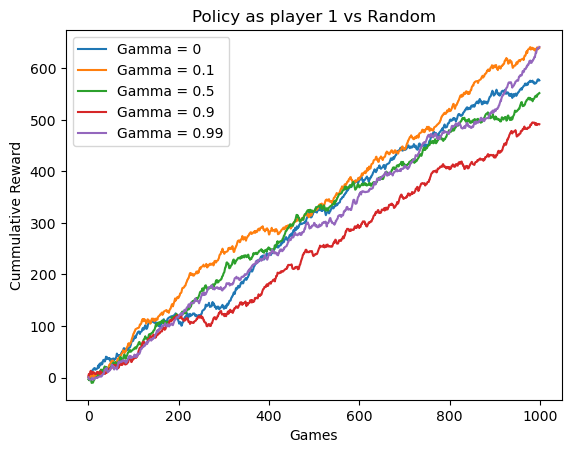

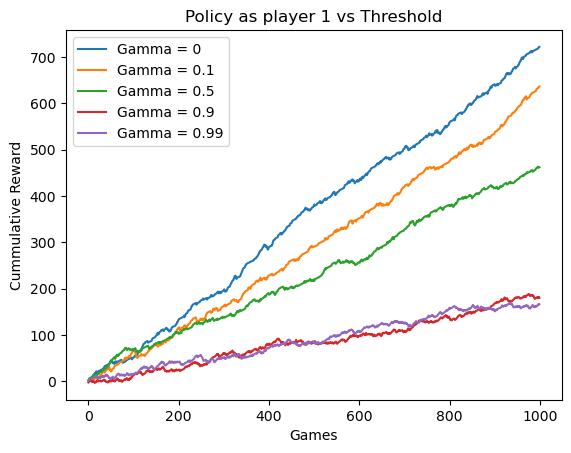

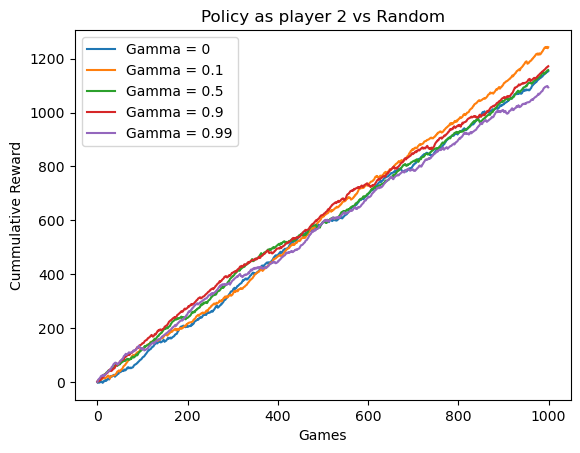

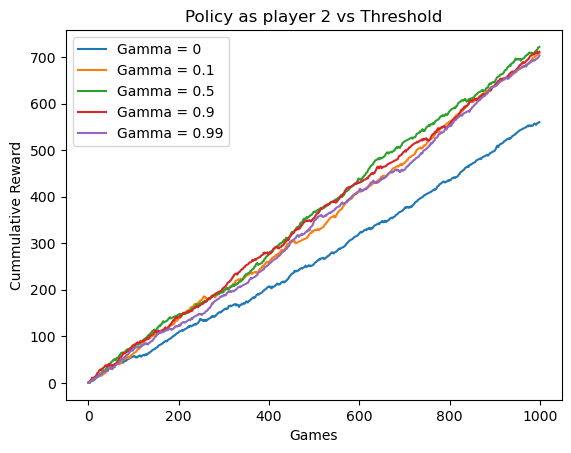

Mean Reward: 0.631
Mean Reward: 0.643


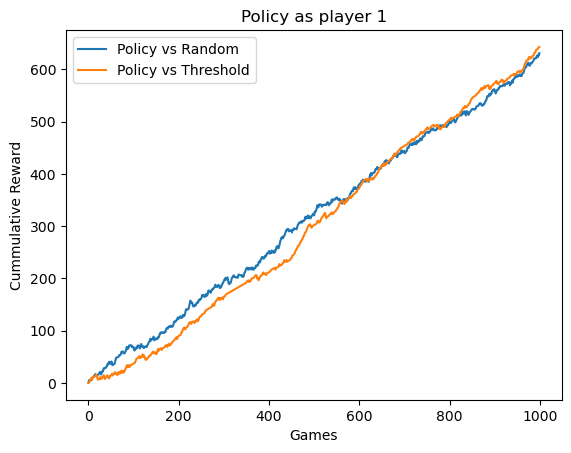

Mean Reward: 1.0755
Mean Reward: 0.66


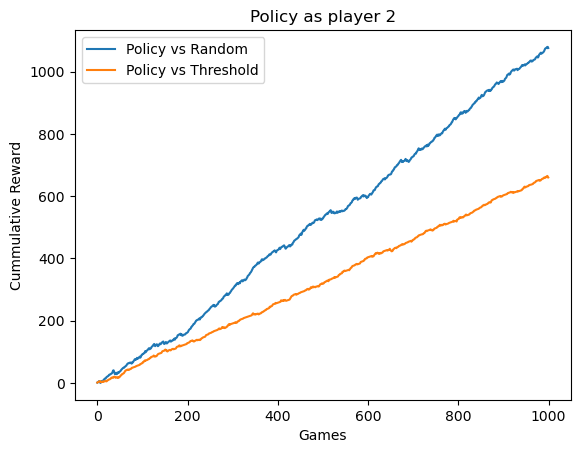

In [31]:
############### Policy Iteration experiments ##################

#Compare different gammas for all kinds of opponents and player ids
gammas = [0, 0.1, 0.5, 0.9, 0.99]
player_ids = [1, 2]
opp_types = ["Random", "Threshold"]
for player_id in player_ids:
  for opp_type in opp_types:
    for gamma in gammas:
      if(player_id == 1):
        if(opp_type == "Random"):
          pk = PokerGame(PolicyAgent(player_id, opp_type, gamma), RandomAgent())
        else:
          pk = PokerGame(PolicyAgent(player_id, opp_type, gamma), ThresholdAgent())
          pk.threshold2 = True
        pk.policy1 = True
      else:
        if(opp_type == "Random"):
          pk = PokerGame(RandomAgent(), PolicyAgent(player_id, opp_type, gamma))
        else:
          pk = PokerGame(ThresholdAgent(), PolicyAgent(player_id, opp_type, gamma))
        pk.policy2 = True

      games = 1000
      cum_reward = np.zeros(games)
      reward = np.zeros(games)
      for i in range(games):
        if(player_id == 1):
          curr_reward , _ = pk.playGame()
        else:
          _ , curr_reward = pk.playGame()
        reward[i] = curr_reward
      cum_reward = np.cumsum(reward)
      games_idx = np.arange(0, games)

      # Plot the first graph
      plt.plot(games_idx, cum_reward, label='Gamma = ' +str(gamma))

    # Add labels and a legend
    plt.title('Policy as player ' +str(player_id) +' vs ' +opp_type)
    plt.xlabel('Games')
    plt.ylabel('Cummulative Reward')
    plt.legend()

    # Display the plot
    plt.show()


#Compare random vs threshold considering their best gamma
epsilon = 0.0000001
player_ids = [1,2]
opp_types = ["Random", "Threshold"]
mean_reward = []
for player_id in player_ids:
    for opp_type in opp_types:
        if(player_id == 1):
            if(opp_type == "Random"):
                pk = PokerGame(PolicyAgent(player_id, opp_type, 0.9, epsilon), RandomAgent())
            else:
                pk.threshold2 = True
                pk = PokerGame(PolicyAgent(player_id, opp_type, 0.1, epsilon), ThresholdAgent())
            pk.policy1 = True
        else:
            if(opp_type == "Random"):
                pk = PokerGame(RandomAgent(), PolicyAgent(player_id, opp_type, 0.9, epsilon))
            else:
                pk = PokerGame(ThresholdAgent(), PolicyAgent(player_id, opp_type, 0.1, epsilon))
            pk.policy2 = True

        games = 1000
        cum_reward = np.zeros(games)
        reward = np.zeros(games)
        for i in range(games):
            if(player_id == 1):
                curr_reward , _ = pk.playGame()
            else:
                 _ , curr_reward = pk.playGame()
            reward[i] = curr_reward
        cum_reward = np.cumsum(reward)
        games_idx = np.arange(0, games)

        # Plot the first graph
        plt.plot(games_idx, cum_reward, label='Policy vs ' +opp_type)
        mean_reward.append(sum(reward)/games)
        print("Mean Reward: "+str(sum(reward)/games))
#     display(Markdown(

#               f"### Mean Rewards: " +
#               f"$\mu_1$={mean_reward[0]}, " +
#               f"$\mu_2$={mean_reward[1]} "

#     ))
    # Add labels and a legend
    plt.title('Policy as player ' +str(player_id))
    plt.xlabel('Games')
    plt.ylabel('Cummulative Reward')
    plt.legend()

    # Display the plot
    plt.show()

## Q-Learning Experiments

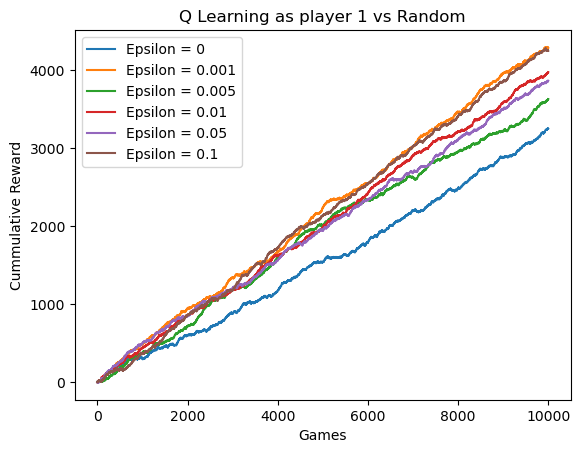

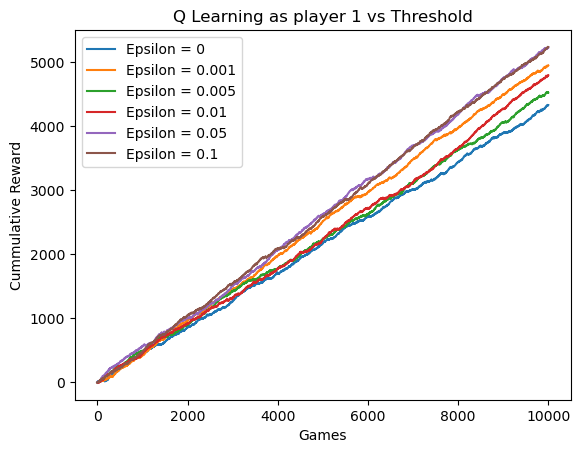

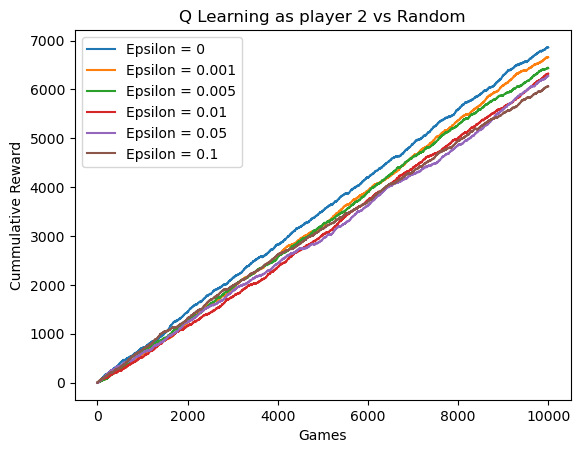

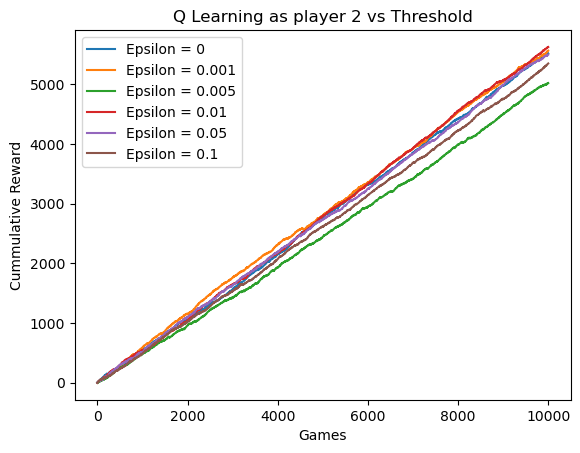

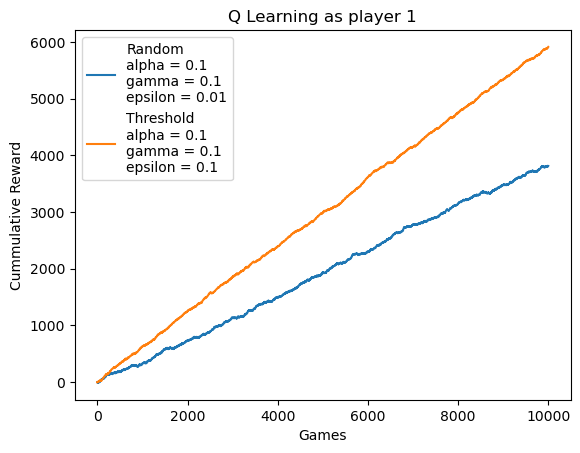

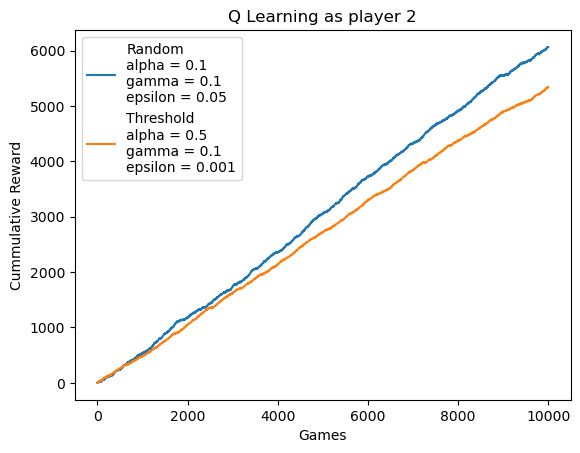

In [6]:



#Compare different epsilons for all kinds of opponents and player ids
epsilons = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
player_ids = [1, 2]
opp_types = ["Random", "Threshold"]
for player_id in player_ids:
  for opp_type in opp_types:
    for epsilon in epsilons:
      if(player_id == 1):
        if(opp_type == "Random"):
          q_agent = QLearningAgent(True, 0.1, 0.1, epsilon)
          pk = PokerGame(q_agent, RandomAgent())
        else:
          q_agent = QLearningAgent(True, 0.1, 0.1, epsilon)
          pk = PokerGame(q_agent, ThresholdAgent())
        pk.q1 = True
      else:
        if(opp_type == "Random"):
          q_agent = QLearningAgent(True, 0.1, 0.1, epsilon)
          pk = PokerGame(RandomAgent(), q_agent)
        else:
          q_agent = QLearningAgent(True, 0.5, 0.1, epsilon)
          pk = PokerGame(ThresholdAgent(), q_agent)
        pk.q2 = True

      num_episodes = 10000
      for episode in range(num_episodes):
          # Play a game
          pk.playGame()

          # Update the Q-values using the rewards obtained in the game
          for i in range(len(pk.states)):
              state = pk.states[i]
              action = pk.actions[i]
              next_state = pk.states[i + 1] if i + 1 < len(pk.states) else None
              reward = pk.rewards[i]
              q_agent.update_q_table(state, action, next_state, reward)

          # Reset the game
          pk.states = []
          pk.actions = []
          pk.rewards = []

      if(player_id == 1):
        pk.player1.q_learn = False
      else:
        pk.player2.q_learn = False

      games = 10000
      cum_reward = np.zeros(games)
      reward = np.zeros(games)
      for i in range(games):
        if(player_id == 1):
          curr_reward , _ = pk.playGame()
        else:
          _ , curr_reward = pk.playGame()
        reward[i] = curr_reward
      cum_reward = np.cumsum(reward)
      games_idx = np.arange(0, games)

      # Plot the first graph
      plt.plot(games_idx, cum_reward, label='Epsilon = ' +str(epsilon))

    # Add labels and a legend
    plt.title('Q Learning as player ' +str(player_id) +' vs ' +opp_type)
    plt.xlabel('Games')
    plt.ylabel('Cummulative Reward')
    plt.legend()

    # Display the plot
    plt.show()


#Compare random vs threshold considering their best aplha, gamma, epsilon

for player_id in player_ids:
  mean_reward = []
  best_gamma = 0.1
  for opp_type in opp_types:
    if(player_id == 1):
      if(opp_type == "Random"):
        best_alpha = 0.1
        best_epsilon = 0.01
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(q_agent, RandomAgent())
      else:
        best_alpha = 0.1
        best_epsilon = 0.1
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(q_agent, ThresholdAgent())
      pk.q1 = True
    else:
      if(opp_type == "Random"):
        best_alpha = 0.1
        best_epsilon = 0.05
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(RandomAgent(), q_agent)
      else:
        best_alpha = 0.5
        best_epsilon = 0.001
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(ThresholdAgent(), q_agent)
      pk.q2 = True

    num_episodes = 10000
    for episode in range(num_episodes):
        # Play a game
        pk.playGame()

        # Update the Q-values using the rewards obtained in the game
        for i in range(len(pk.states)):
            state = pk.states[i]
            action = pk.actions[i]
            next_state = pk.states[i + 1] if i + 1 < len(pk.states) else None
            reward = pk.rewards[i]
            q_agent.update_q_table(state, action, next_state, reward)

        # Reset the game
        pk.states = []
        pk.actions = []
        pk.rewards = []

    if(player_id == 1):
      pk.player1.q_learn = False
    else:
      pk.player2.q_learn = False

    games = 10000
    cum_reward = np.zeros(games)
    reward = np.zeros(games)
    for i in range(games):
      if(player_id == 1):
        curr_reward , _ = pk.playGame()
      else:
        _ , curr_reward = pk.playGame()
      reward[i] = curr_reward
    mean_reward.append(np.mean(reward))
    cum_reward = np.cumsum(reward)
    games_idx = np.arange(0, games)

    # Plot the first graph
    plt.plot(games_idx, cum_reward, label=str(opp_type) +'\nalpha = ' +str(best_alpha) +'\ngamma = ' +str(best_gamma) +'\nepsilon = ' +str(best_epsilon))

#   display(Markdown(

#                 f"### Mean Rewards: " +
#                 f"$\mu_1$={mean_reward[0]}, " +
#                 f"$\mu_2$={mean_reward[1]} "

#     ))

  # Add labels and a legend
  plt.title('Q Learning as player '+str(player_id))
  plt.xlabel('Games')
  plt.ylabel('Cummulative Reward')
  plt.legend()

  # Display the plot
  plt.show()


## Policy Iteration vs Q-Learning Performance

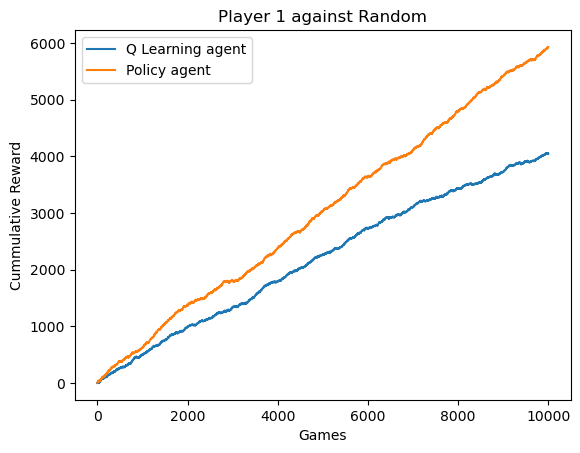

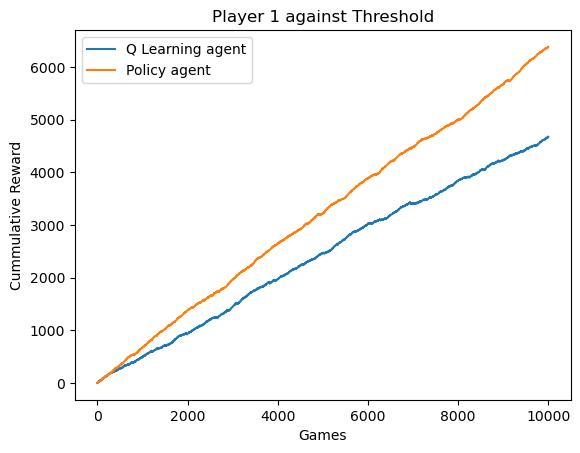

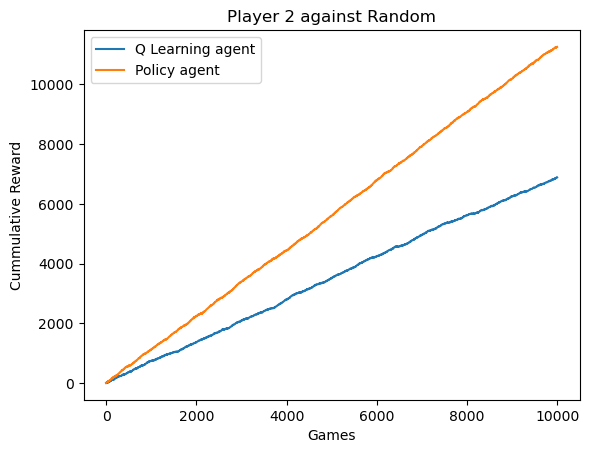

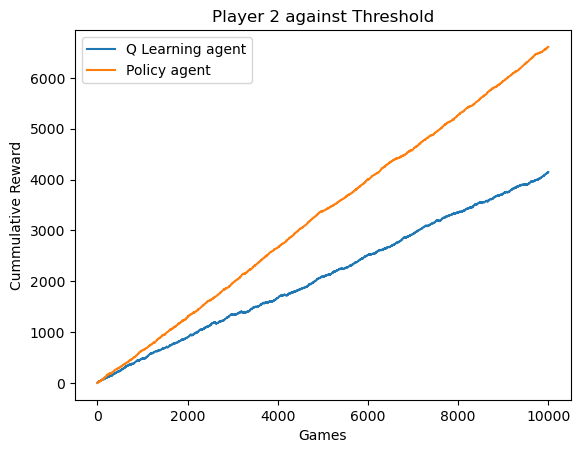

In [3]:
#Compare policy vs q learning
player_ids = [1, 2]
opp_types = ["Random", "Threshold"]
mean_reward = []

for player_id in player_ids:
  for opp_type in opp_types:
    #Q Learning
    best_gamma = 0.1
    if(player_id == 1):
      if(opp_type == "Random"):
        best_alpha = 0.1
        best_epsilon = 0.01  #0.01
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(q_agent, RandomAgent())
      else:
        best_alpha = 0.1
        best_epsilon = 0.01  #0.1
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(q_agent, ThresholdAgent())
      pk.q1 = True
    else:
      if(opp_type == "Random"):
        best_alpha = 0.1
        best_epsilon = 0.01  #0.005
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(RandomAgent(), q_agent)
      else:
        best_alpha = 0.1   #0.5
        best_epsilon = 0.01   #0.001
        q_agent = QLearningAgent(True, best_alpha, best_gamma, best_epsilon)
        pk = PokerGame(ThresholdAgent(), q_agent)
      pk.q2 = True

    num_episodes = 10000
    for episode in range(num_episodes):
        # Play a game
        pk.playGame()

        # Update the Q-values using the rewards obtained in the game
        for i in range(len(pk.states)):
            state = pk.states[i]
            action = pk.actions[i]
            next_state = pk.states[i + 1] if i + 1 < len(pk.states) else None
            reward = pk.rewards[i]
            q_agent.update_q_table(state, action, next_state, reward)

        # Reset the game
        pk.states = []
        pk.actions = []
        pk.rewards = []

    if(player_id == 1):
      pk.player1.q_learn = False
    else:
      pk.player2.q_learn = False

    games = 10000
    cum_reward = np.zeros(games)
    reward = np.zeros(games)
    for i in range(games):
      if(player_id == 1):
        curr_reward , _ = pk.playGame()
      else:
        _ , curr_reward = pk.playGame()
      reward[i] = curr_reward
    mean_reward.append(np.mean(reward))
    cum_reward = np.cumsum(reward)
    games_idx = np.arange(0, games)

    # Plot the first graph
    plt.plot(games_idx, cum_reward, label='Q Learning agent')

    #Policy
    gamma=0.1
    if(player_id == 1):
      if(opp_type == "Random"):
        pk = PokerGame(PolicyAgent(player_id, opp_type, gamma), RandomAgent())
      else:
        pk = PokerGame(PolicyAgent(player_id, opp_type, gamma), ThresholdAgent())
        pk.threshold2 = True
      pk.policy1 = True
    else:
      if(opp_type == "Random"):
        pk = PokerGame(RandomAgent(), PolicyAgent(player_id, opp_type, gamma))
      else:
        pk = PokerGame(ThresholdAgent(), PolicyAgent(player_id, opp_type, 0.5))
      pk.policy2 = True

    games = 10000
    cum_reward = np.zeros(games)
    reward = np.zeros(games)
    for i in range(games):
      if(player_id == 1):
        curr_reward , _ = pk.playGame()
      else:
        _ , curr_reward = pk.playGame()
      reward[i] = curr_reward
    cum_reward = np.cumsum(reward)
    games_idx = np.arange(0, games)

    # Plot the first graph
    plt.plot(games_idx, cum_reward, label='Policy agent')

    # Add labels and a legend
    plt.title('Player '+str(player_id) +' against '+opp_type)
    plt.xlabel('Games')
    plt.ylabel('Cummulative Reward')
    plt.legend()

    # Display the plot
    plt.show()

## Try to play versus the available Agents

In [8]:
    new_pk = PokerGame(None,None,True)
    new_pk.InitPlayers()
    new_pk.playGame()
    

Choose your player type:(Random, Human, Threshold, Policy, QLearning) Human
Choose opponent type (Random, Threshold, Human, Policy, QLearning): QLearning

Round 1
Player 1's turn

-----Your Hand-----
┌─────────┐
│A        │
│         │
│         │
│    ♠    │
│         │
│         │
│        A│
└─────────┘
Please enter an action (call, fold, check or raise): raise
Player 1 has raised.
Player 2's turn
Player 2 has raised.
Player 1's turn

-----Your Hand-----
┌─────────┐
│A        │
│         │
│         │
│    ♠    │
│         │
│         │
│        A│
└─────────┘
Please enter an action (call, fold, check or raise): call
Player 1 has called.

Round 2
Player 1's turn

-----Your Hand-----
┌─────────┐
│A        │
│         │
│         │
│    ♠    │
│         │
│         │
│        A│
└─────────┘
-------Public Cards---------
┌─────────┐
│10       │
│         │
│         │
│    ♦    │
│         │
│         │
│       01│
└─────────┘
┌─────────┐
│10       │
│         │
│         │
│    ♥    │


(4.5, -4.5)